# Нейронные сети: Perceptron → MLP → Forward/Backprop → Optimizers  

## Что вы поймёте к концу урока
- Что такое **однослойный персептрон** и почему он решает **только линейно-разделимые** задачи.
- Что такое **многослойный персептрон (MLP)** и как он решает нелинейные задачи.
- Что такое **прямое распространение (forward pass)**.
- Что такое **обратное распространение ошибки (backprop)** — как считаются градиенты.
- Что такое **оптимизация**, **функция потерь**, **градиентный спуск**.
- Что делают оптимизаторы **SGD / Momentum / Adam** (интуитивно + простая реализация).

> Мы работаем на маленьких синтетических данных, чтобы было ясно *как всё устроено*. В реальном проекте логика та же, только данных больше и чаще используется PyTorch/TensorFlow.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import accuracy_score

np.set_printoptions(precision=4, suppress=True)
rng = np.random.default_rng(42)
print("Ready!")

Ready!


In [4]:
def plot_2d_data(X, y, title=""):
    """Простой scatter для 2D данных."""
    plt.figure(figsize=(6,4))
    plt.scatter(X[:,0], X[:,1], c=y, s=15, alpha=0.8)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    plt.show()

def plot_decision_boundary_2d(predict_fn, X, y, title=""):
    """Рисует границу решений для 2D данных."""
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                         np.linspace(y_min, y_max, 250))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = predict_fn(grid).reshape(xx.shape)

    plt.figure(figsize=(6,4))
    plt.contourf(xx, yy, zz, alpha=0.25, levels=[-0.5,0.5,1.5])
    plt.scatter(X[:,0], X[:,1], c=y, s=15, alpha=0.85)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    plt.show()

# 1) Данные для демонстрации (линейные vs нелинейные)

Мы сделаем 2 датасета:
1) **Blobs** — два облака точек (почти линейно разделимо)  
2) **Moons** — “две луны” (нелинейно разделимо)  

Зачем это нужно:
- персептрон “любит” линейные задачи
- MLP нужен, когда граница сложная


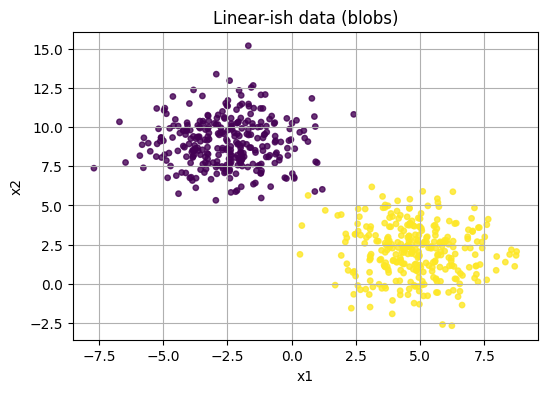

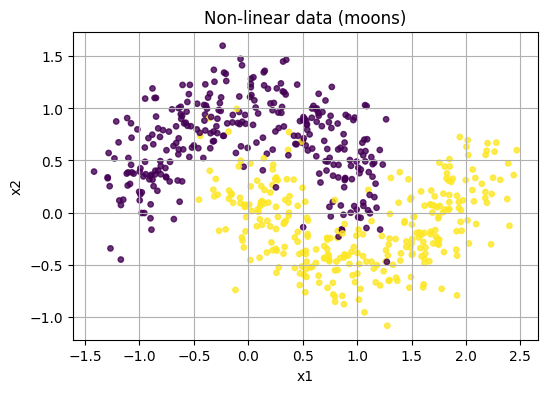

In [5]:
# 1.1) Линейно-разделимый датасет
X_lin, y_lin = make_blobs(n_samples=600, centers=2, cluster_std=1.6, random_state=42)
plot_2d_data(X_lin, y_lin, "Linear-ish data (blobs)")

# 1.2) Нелинейный датасет
X_moon, y_moon = make_moons(n_samples=600, noise=0.22, random_state=42)
plot_2d_data(X_moon, y_moon, "Non-linear data (moons)")

# 2) Однослойный персептрон

## 2.1) Идея “нейрона”
Персептрон — простая модель для бинарной классификации:

1) линейная комбинация:
$ z = w_0 + w_1 x_1 + w_2 x_2 + \dots $
2) пороговая функция (**step**):
$ \hat{y} = \begin{cases}
1, & z \ge 0 \\
0, & z < 0
\end{cases} $

Это значит: модель строит **прямую** (в 2D) / **гиперплоскость** (в многомерном случае).

### Ограничение
Персептрон решает только **линейно-разделимые** задачи (XOR / “две луны” — нет).


## 2.2) Правило обучения персептрона (Rosenblatt)

Если модель ошиблась на примере (x, y), то подкручиваем веса:

$$ w \leftarrow w + \eta (y - \hat{y}) x $$
$$ b \leftarrow b + \eta (y - \hat{y}) $$

где $ \eta $ — learning rate.


epoch=05 errors=3
epoch=10 errors=5
epoch=15 errors=5
epoch=20 errors=5
epoch=25 errors=5
Train accuracy (linear): 0.9966666666666667


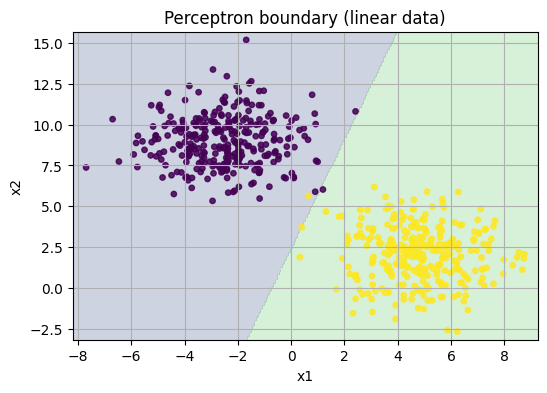

In [6]:
def step(z):
    """Пороговая функция: возвращает 0/1."""
    return (z >= 0).astype(int)

class Perceptron:
    def __init__(self, lr=0.1, n_epochs=20, random_state=42):
        self.lr = lr
        self.n_epochs = n_epochs
        self.rng = np.random.default_rng(random_state)
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = self.rng.normal(0, 0.1, size=n_features)
        self.b = 0.0

        for epoch in range(self.n_epochs):
            errors = 0
            for i in range(n_samples):
                z = X[i] @ self.w + self.b
                y_hat = int(z >= 0)
                update = self.lr * (y[i] - y_hat)
                if update != 0:
                    errors += 1
                self.w += update * X[i]
                self.b += update
            if (epoch+1) % 5 == 0:
                print(f"epoch={epoch+1:02d} errors={errors}")
        return self

    def predict(self, X):
        z = X @ self.w + self.b
        return step(z)

# Персептрон на линейных данных
perc = Perceptron(lr=0.05, n_epochs=25, random_state=42).fit(X_lin, y_lin)
pred_lin = perc.predict(X_lin)
print("Train accuracy (linear):", accuracy_score(y_lin, pred_lin))

plot_decision_boundary_2d(perc.predict, X_lin, y_lin, "Perceptron boundary (linear data)")

## 2.3) Персептрон на нелинейных данных

На “лунах” одна прямая не справляется.


epoch=05 errors=106
epoch=10 errors=102
epoch=15 errors=100
epoch=20 errors=106
epoch=25 errors=112
Train accuracy (moons): 0.6933333333333334


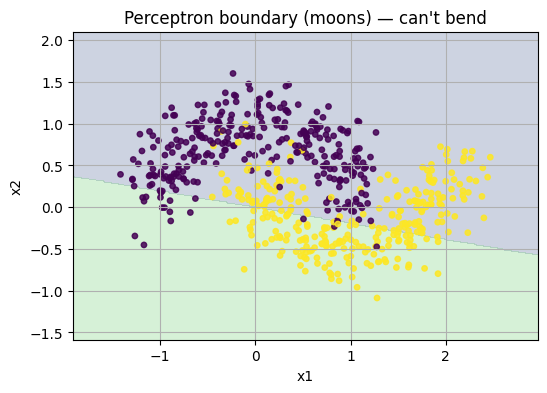

In [7]:
perc2 = Perceptron(lr=0.05, n_epochs=25, random_state=42).fit(X_moon, y_moon)
pred_m = perc2.predict(X_moon)
print("Train accuracy (moons):", accuracy_score(y_moon, pred_m))

plot_decision_boundary_2d(perc2.predict, X_moon, y_moon, "Perceptron boundary (moons) — can't bend")

# 3) Логистический нейрон (шаг к нейросетям)

Персептрон использует step-функцию (не гладкая), поэтому неудобно считать производные.

Используем **sigmoid**:
$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$
Тогда модель даёт вероятность класса 1: $ p = \sigma(z) $.

## 3.1) Log loss (cross-entropy)
$ L(y, p) = -\left(y\log(p) + (1-y)\log(1-p)\right) $


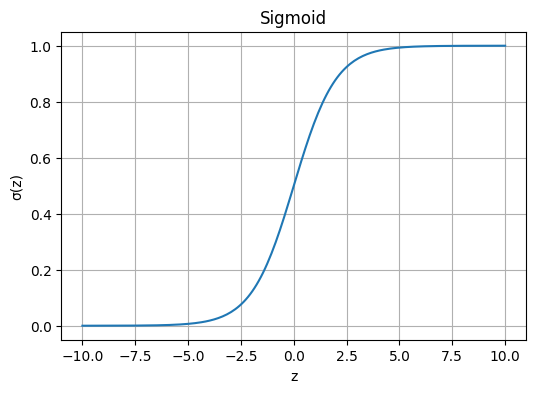

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logloss(y_true, p_pred, eps=1e-15):
    p = np.clip(p_pred, eps, 1-eps)
    return -np.mean(y_true*np.log(p) + (1-y_true)*np.log(1-p))

# Sigmoid график
z = np.linspace(-10, 10, 200)
plt.figure(figsize=(6,4))
plt.plot(z, sigmoid(z))
plt.title("Sigmoid")
plt.xlabel("z")
plt.ylabel("σ(z)")
plt.grid(True)
plt.show()

## 3.2) Градиентный спуск для логистического нейрона

Модель:
- z = Xw + b
- p = sigmoid(z)

Градиенты (результат backprop для 1 слоя):
- dL/dz = (p - y)
- dL/dw = Xᵀ(p - y) / n
- dL/db = mean(p - y)

Шаг GD:
- w ← w - lr * grad_w
- b ← b - lr * grad_b


epoch=500 loss=0.0123
epoch=1000 loss=0.0108
epoch=1500 loss=0.0101
epoch=2000 loss=0.0097
epoch=2500 loss=0.0093


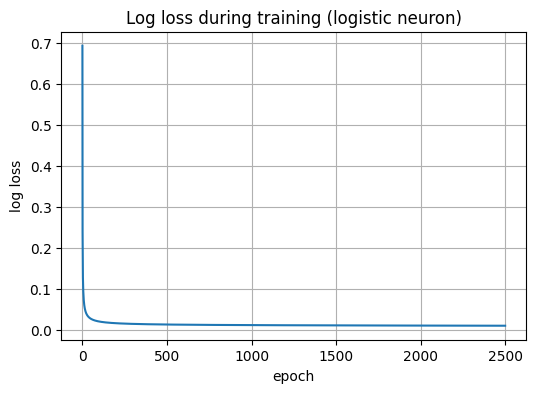

Train accuracy: 0.9966666666666667


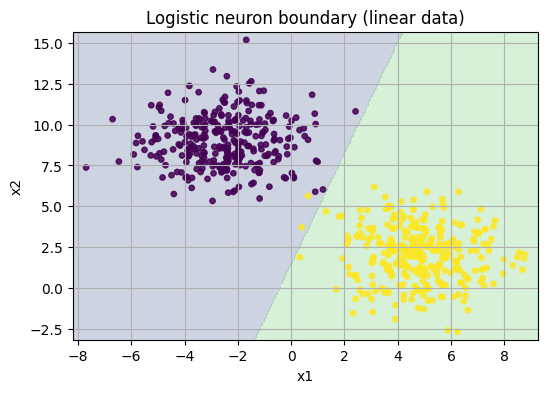

In [9]:
def train_logistic_gd(X, y, lr=0.2, n_epochs=3000):
    n, d = X.shape
    w = np.zeros(d)
    b = 0.0
    history = []

    for epoch in range(n_epochs):
        z = X @ w + b
        p = sigmoid(z)
        loss = logloss(y, p)
        history.append(loss)

        dz = (p - y)                 # (n,)
        grad_w = (X.T @ dz) / n      # (d,)
        grad_b = dz.mean()

        w -= lr * grad_w
        b -= lr * grad_b

        if (epoch+1) % 500 == 0:
            print(f"epoch={epoch+1} loss={loss:.4f}")
    return w, b, np.array(history)

w_lr, b_lr, hist = train_logistic_gd(X_lin, y_lin, lr=0.15, n_epochs=2500)

plt.figure(figsize=(6,4))
plt.plot(hist)
plt.title("Log loss during training (logistic neuron)")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.grid(True)
plt.show()

def predict_logistic(X, thr=0.5):
    p = sigmoid(X @ w_lr + b_lr)
    return (p >= thr).astype(int)

print("Train accuracy:", accuracy_score(y_lin, predict_logistic(X_lin)))
plot_decision_boundary_2d(lambda X: predict_logistic(X, 0.5), X_lin, y_lin, "Logistic neuron boundary (linear data)")

# 4) Многослойный персептрон (MLP)

Чтобы получить **нелинейную границу**, добавляем скрытый слой + нелинейность.

Простейший MLP для бинарной классификации (2 слоя):
- Hidden: h = tanh(XW1 + b1)
- Output: p = sigmoid(hW2 + b2)

## 4.1) Forward pass
Считаем значения от входа к выходу.

## 4.2) Backprop
Считаем градиенты параметров (W1,b1,W2,b2) по правилу цепочки.


In [10]:
def tanh(x):
    return np.tanh(x)

def dtanh(x):
    t = np.tanh(x)
    return 1 - t*t

class MLP2Layer:
    """MLP: hidden(tanh) -> output(sigmoid)."""
    def __init__(self, n_hidden=16, lr=0.05, n_epochs=4000, optimizer="sgd", random_state=42):
        self.n_hidden = n_hidden
        self.lr = lr
        self.n_epochs = n_epochs
        self.optimizer = optimizer
        self.rng = np.random.default_rng(random_state)

        self.W1 = None; self.b1 = None
        self.W2 = None; self.b2 = None

        # optimizer state
        self.v = {}
        self.m = {}
        self.t = 0

    def params(self):
        return {"W1": self.W1, "b1": self.b1, "W2": self.W2, "b2": self.b2}

    def _init_params(self, d):
        # simple Xavier-like init
        self.W1 = self.rng.normal(0, 1/np.sqrt(d), size=(d, self.n_hidden))
        self.b1 = np.zeros(self.n_hidden)
        self.W2 = self.rng.normal(0, 1/np.sqrt(self.n_hidden), size=(self.n_hidden, 1))
        self.b2 = np.zeros(1)
        self.v = {k: np.zeros_like(v) for k, v in self.params().items()}
        self.m = {k: np.zeros_like(v) for k, v in self.params().items()}
        self.t = 0

    def forward(self, X):
        z1 = X @ self.W1 + self.b1          # (n, hidden)
        h  = tanh(z1)                       # (n, hidden)
        z2 = h @ self.W2 + self.b2          # (n, 1)
        p  = sigmoid(z2).reshape(-1)        # (n,)
        cache = (X, z1, h, z2, p)
        return p, cache

    def backward(self, cache, y_true):
        X, z1, h, z2, p = cache
        n = X.shape[0]
        y = y_true.reshape(-1)

        dz2 = (p - y).reshape(-1, 1)        # (n,1)
        dW2 = (h.T @ dz2) / n               # (hidden,1)
        db2 = dz2.mean(axis=0)              # (1,)

        dh  = dz2 @ self.W2.T               # (n, hidden)
        dz1 = dh * dtanh(z1)                # (n, hidden)

        dW1 = (X.T @ dz1) / n               # (d, hidden)
        db1 = dz1.mean(axis=0)              # (hidden,)

        return {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}

    def _step_sgd(self, grads):
        for k in grads:
            self.params()[k][...] -= self.lr * grads[k]

    def _step_momentum(self, grads, beta=0.9):
        for k in grads:
            self.v[k] = beta*self.v[k] + (1-beta)*grads[k]
            self.params()[k][...] -= self.lr * self.v[k]

    def _step_adam(self, grads, beta1=0.9, beta2=0.999, eps=1e-8):
        self.t += 1
        for k in grads:
            self.m[k] = beta1*self.m[k] + (1-beta1)*grads[k]
            self.v[k] = beta2*self.v[k] + (1-beta2)*(grads[k]**2)
            m_hat = self.m[k] / (1 - beta1**self.t)
            v_hat = self.v[k] / (1 - beta2**self.t)
            self.params()[k][...] -= self.lr * m_hat / (np.sqrt(v_hat) + eps)

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).reshape(-1)
        n, d = X.shape
        self._init_params(d)

        self.loss_history_ = []
        for epoch in range(self.n_epochs):
            p, cache = self.forward(X)
            loss = logloss(y, p)
            self.loss_history_.append(loss)

            grads = self.backward(cache, y)

            if self.optimizer == "sgd":
                self._step_sgd(grads)
            elif self.optimizer == "momentum":
                self._step_momentum(grads)
            elif self.optimizer == "adam":
                self._step_adam(grads)
            else:
                raise ValueError("optimizer must be one of: sgd, momentum, adam")

            if (epoch+1) % 800 == 0:
                pred = (p >= 0.5).astype(int)
                acc = (pred == y).mean()
                print(f"epoch={epoch+1:4d} loss={loss:.4f} acc={acc:.3f}")
        return self

    def predict_proba(self, X):
        p, _ = self.forward(X)
        return p

    def predict(self, X, thr=0.5):
        return (self.predict_proba(X) >= thr).astype(int)

## 4.3) Обучаем MLP на “лунах” (там, где персептрон не справился)

epoch= 800 loss=0.1023 acc=0.963
epoch=1600 loss=0.0922 acc=0.965
epoch=2400 loss=0.0803 acc=0.965
epoch=3200 loss=0.0703 acc=0.970
epoch=4000 loss=0.0657 acc=0.972
epoch=4800 loss=0.0640 acc=0.973


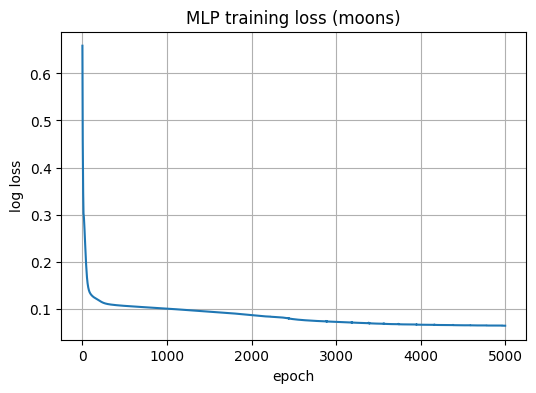

Train accuracy (moons): 0.9766666666666667


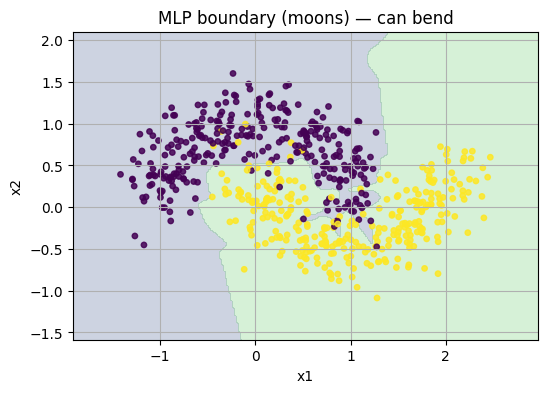

In [11]:
mlp = MLP2Layer(n_hidden=16, lr=0.05, n_epochs=5000, optimizer="adam", random_state=42)
mlp.fit(X_moon, y_moon)

plt.figure(figsize=(6,4))
plt.plot(mlp.loss_history_)
plt.title("MLP training loss (moons)")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.grid(True)
plt.show()

pred = mlp.predict(X_moon)
print("Train accuracy (moons):", accuracy_score(y_moon, pred))

plot_decision_boundary_2d(lambda X: mlp.predict(X, thr=0.5), X_moon, y_moon, "MLP boundary (moons) — can bend")

# 5) Оптимизация и оптимизаторы

- **SGD**: самый простой шаг по градиенту  
- **Momentum**: добавляет “инерцию” (ускоряет в одном направлении)  
- **Adam**: адаптивные шаги для каждого параметра (часто хорош “из коробки”)  


epoch= 800 loss=0.3043 acc=0.875
epoch=1600 loss=0.2817 acc=0.887
epoch=2400 loss=0.2233 acc=0.923
epoch= 800 loss=0.3067 acc=0.875
epoch=1600 loss=0.2972 acc=0.878
epoch=2400 loss=0.2705 acc=0.897
epoch= 800 loss=0.1023 acc=0.963
epoch=1600 loss=0.0922 acc=0.965
epoch=2400 loss=0.0803 acc=0.965


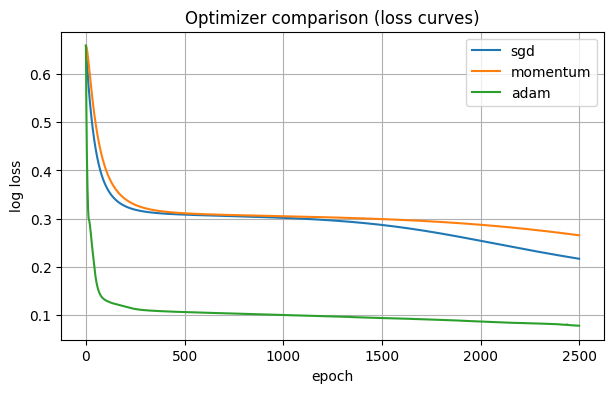

In [12]:
# Сравнение оптимизаторов (быстро, на меньшем числе эпох)
configs = [
    ("sgd", 0.08, 2500),
    ("momentum", 0.06, 2500),
    ("adam", 0.05, 2500),
]

histories = {}
for opt, lr, epochs in configs:
    m = MLP2Layer(n_hidden=16, lr=lr, n_epochs=epochs, optimizer=opt, random_state=42)
    m.fit(X_moon, y_moon)
    histories[opt] = m.loss_history_

plt.figure(figsize=(7,4))
for opt in histories:
    plt.plot(histories[opt], label=opt)
plt.title("Optimizer comparison (loss curves)")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.grid(True)
plt.legend()
plt.show()

---
# 10 заданий (задание → подсказка → код с пропусками)

**Правило:** дополняйте пропуски `_____`, не переписывайте всё.


## Задание 1

**Задание:** Допишите step(z), чтобы возвращались 0/1 для массива z.

**Подсказка:** используйте (z >= 0).astype(int)


In [13]:
import numpy as np

def step_student(z):
    return (z >= 0).astype(int)

z = np.array([-2.0, -0.1, 0.0, 0.2, 5.0])
print(step_student(z))  # ожидаем: [0 0 1 1 1]

[0 0 1 1 1]


## Задание 2

**Задание:** Дописать predict для персептрона: z = X@w + b → step(z).

**Подсказка:** оператор @ и функция step


In [14]:
w = np.array([0.4, -0.2])
b = -0.1

def predict_perc(X):
    z = X @ w + b
    return step(z)

X_test_small = np.array([[0,0],[1,0],[0,1],[2,1]])
print(predict_perc(X_test_small))

[0 1 0 1]


## Задание 3

**Задание:** Сделайте 1 шаг обновления персептрона для одного объекта (x,y).

**Подсказка:** update = lr*(y - y_hat); w += update*x; b += update


In [15]:
x = np.array([1.5, -0.3])
y = 1
lr = 0.05
w = np.array([0.1, 0.2])
b = 0.0

z = x @ w + b
y_hat = int(z >= 0)

update = lr * (y - y_hat)
w = w + update * x
b = b + update

print("w:", w, "b:", b)

w: [0.1 0.2] b: 0.0


## Задание 4

**Задание:** Допишите sigmoid(z). Проверьте на z=[-2,0,2].

**Подсказка:** σ(z)=1/(1+exp(-z))


In [16]:
import numpy as np

def sigmoid_student(z):
    return 1 / (1 + np.exp(-z))

z = np.array([-2.0, 0.0, 2.0])
print(np.round(sigmoid_student(z), 4))  # ~ [0.1192 0.5 0.8808]

[0.1192 0.5    0.8808]


## Задание 5

**Задание:** Допишите logloss(y,p).

**Подсказка:** p = clip(p, eps, 1-eps)


In [19]:
import numpy as np

def logloss_student(y_true, p_pred, eps=1e-15):
    p = np.clip(p_pred, eps, 1-eps)
    return -np.mean(y_true*np.log(p) + (1-y_true)*np.log(1-p))

y = np.array([1,0,1,0])
p = np.array([0.9,0.2,0.7,0.1])
print(logloss_student(y,p))

0.1976348816421487


## Задание 6

**Задание:** В логистическом GD допишите grad_w и grad_b и сделайте 50 шагов.

**Подсказка:** dz=(p-y); grad_w=X.T@dz/n; grad_b=mean(dz)


In [21]:
import numpy as np

X = X_lin[:200]
y = y_lin[:200]

n, d = X.shape
w = np.zeros(d)
b = 0.0
lr = 0.2

for epoch in range(50):
    z = X @ w + b
    p = sigmoid(z)
    dz = (p - y)
    grad_w = (X.T @ dz) / n
    grad_b =np.mean(dz)
    w -= lr * grad_w
    b -= lr * grad_b

print("w:", np.round(w,4), "b:", np.round(b,4))

w: [ 1.2641 -0.3035] b: 0.1898


## Задание 7

**Задание:** В MLP forward допишите z1, h, z2, p.

**Подсказка:** z1=X@W1+b1; h=tanh(z1); z2=h@W2+b2; p=sigmoid(z2)


In [22]:
import numpy as np

X = np.array([[0.5, -1.0],
              [1.0,  0.3]])
W1 = np.array([[0.2, -0.1, 0.05],
               [0.1,  0.3, -0.2]])
b1 = np.array([0.0, 0.1, 0.0])
W2 = np.array([[0.4],
               [-0.2],
               [0.1]])
b2 = np.array([0.0])

z1 = X @ W1 + b1
h  = np.tanh(z1)
z2 = h@W2 + b2
p  = 1 / (1 + np.exp(z2) )
print("p:", np.round(p.reshape(-1),4))

p: [0.4822 0.4821]


## Задание 8

**Задание:** Backprop: dz2 = (p - y). Посчитайте dW2 и db2.

**Подсказка:** dW2 = h.T@dz2 / n; db2 = mean(dz2)


In [23]:
import numpy as np

h = np.array([[0.1, 0.2],
              [0.0, 0.3],
              [0.2, 0.1]])
p = np.array([0.7, 0.2, 0.9])
y = np.array([1, 0, 1])

n = h.shape[0]
dz2 = (p - y).reshape(-1,1)

dW2 = (h .T @ dz2) / n
db2 = np.mean(dz2)

print("dW2:", np.round(dW2,4))
print("db2:", np.round(db2,4))

dW2: [[-0.0167]
 [-0.0033]]
db2: -0.0667


## Задание 9

**Задание:** Сделайте шаг SGD обновления: W -= lr*grad.

**Подсказка:** W[...] = W - lr*grad


In [25]:
import numpy as np

W = np.array([[1.0, -2.0],
              [0.5,  0.2]])
grad = np.array([[0.1, -0.3],
                 [0.05, 0.4]])
lr = 0.2

W[:] = W[:] - lr * grad
print(W)

[[ 0.98 -1.94]
 [ 0.49  0.12]]


## Задание 10

**Задание:** Сравните SGD и Adam: обучите MLP на moons по 2000 эпох и выведите accuracy.

**Подсказка:** optimizer='sgd'/'adam', затем accuracy_score(y, pred)


In [27]:
from sklearn.metrics import accuracy_score

m_sgd = MLP2Layer(n_hidden=16, lr=0.1, n_epochs=2000, optimizer='sgd', random_state=42)
m_sgd.fit(X_moon, y_moon)
pred_sgd = m_sgd.predict(X_moon)
print("SGD acc:", accuracy_score(y_moon, pred_sgd))

m_adam = MLP2Layer(n_hidden=16, lr=0.01, n_epochs=2000, optimizer='adam', random_state=42)
m_adam.fit(X_moon, y_moon)
pred_adam = m_adam.predict(X_moon)
print("Adam acc:", accuracy_score(y_moon, pred_adam))

epoch= 800 loss=0.3015 acc=0.878
epoch=1600 loss=0.2539 acc=0.910
SGD acc: 0.9266666666666666
epoch= 800 loss=0.1135 acc=0.963
epoch=1600 loss=0.1071 acc=0.963
Adam acc: 0.9633333333333334


---
## Мини-итоги
- **Персептрон** = прямая граница, быстро и просто, но ограничен линейностью.
- **MLP** + нелинейность = может строить “изогнутые” границы.
- **Forward**: посчитать выходы слоёв.
- **Backprop**: посчитать градиенты параметров.
- **Оптимизация**: уменьшаем loss градиентными методами.
- **Adam** часто работает хорошо “из коробки”, но важно понимать базовый SGD.
